# Errors

## Machine Accuracy

In order to quantify round-off errors, we define:
\begin{align}
\text{(relative error)} \equiv \frac{x - \bar{x}}{x}.
\end{align}

If we use a numeral system of base $b$ and keep $p$ significant digits, the machine accuracy is
\begin{align}
\epsilon = \left(\frac{b}{2}\right) b^{-p}.
\end{align}

A single-precision floating-point number, which stores 23 significant digits in binary (the mantissa), provides a machine accuracy of approximately $\epsilon_\mathrm{single} = 2^{-23} \approx 10^{-7}$ in decimal.
In contrast, a double-precision floating-point number, with 52 significant binary digits, corresponds to a much finer machine accuracy of about $\epsilon_\mathrm{double} = 2^{-52} \approx 2\times10^{-16}$ in decimal.

## Accumulation of round-off errors

Round-off errors accumulate during iterative processes or summations when many floating-point operations are involved. This effect becomes more pronounced as the number of operations increases.

In [1]:
def simple_sum(x, n):
    s = 0.0
    for i in range(n):
        s += x
    return s

In [2]:
x = 0.1
n = 10
s = simple_sum(x, n)
e = abs(s/n - x) / x
print(f"Mean = {s}; relative error = {e}")

Mean = 0.9999999999999999; relative error = 1.3877787807814457e-16


We may study how the relative error grows with the number of summations.
The following figure illustrates the instability of the naive summation method.

In [3]:
N        = [2**p for p in range(10,25)]
E_simple = [abs(simple_sum(x, n)/n - x) / x for n in N]

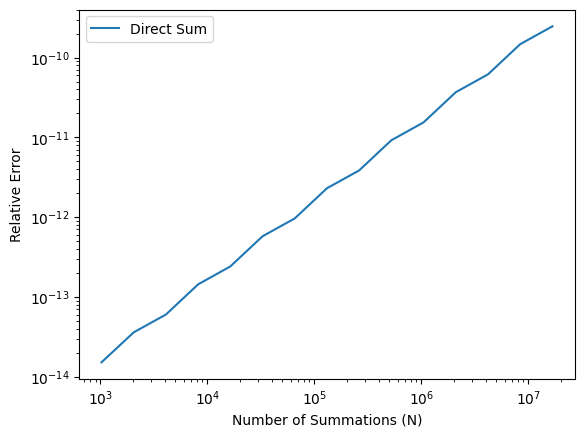

In [4]:
from matplotlib import pyplot as plt

plt.loglog(N, E_simple, label='Direct Sum')
plt.xlabel('Number of Summations (N)')
plt.ylabel('Relative Error')
plt.legend()
plt.show() # optional in Jupyter Notebook

### The Kahan Summation Algorithm

The Kahan summation algorithm is a method designed to minimize round-off errors during summation.
By maintaining a separate compensation variable, it accounts for small errors that would otherwise be lost.

In [ ]:
def Kahan_sum(x, n):
    c = 0.0 # compensation for lost low-order bits
    s = 0.0
    for i in range(n):
        xp = x - c # apply compensation
        c  = ((s + xp) - s) - xp # update compensation
        s += x - c # update sum
    return s

In [ ]:
E_Kahan = [abs(Kahan_sum(x, n)/n - x) / x for n in N]

In [ ]:
plt.loglog(N, E_simple, label='Simple Sum')
plt.loglog(N, E_Kahan,  label='Kahan Sum')
plt.xlabel('Number of Summations (N)')
plt.ylabel('Relative Error')
plt.legend()
plt.show() # optional in Jupyter Notebook

Discussion:

* Compare the relative errors from the naive summation and Kahan summation.
* How does the Kahan summation reduce the accumulation of round-off errors?
* Why is this method particularly effective for long summations?

### Partial Pairwise Summation

In practice, it is not recommended to write a for-loop in Python to sum numbers.
Instead, `numpy.sum()` is usually a better choice.
The `numpy.sum()`  uses a more numerically accurate "partial pairwise summation" (see its [documentation](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) and [source code](https://github.com/numpy/numpy/blob/v2.2.0/numpy/_core/fromnumeric.py#L2338-L2469)).
Here, we simply will try it out.

In [ ]:
import numpy as np

def numpy_sum(x, n):
    X = np.repeat(x, n)
    return np.sum(X)

In [ ]:
E_numpy = [abs(numpy_sum(x, n)/n - x) / x for n in N]

In [ ]:
plt.loglog(N, E_simple, label='Simple Sum')
plt.loglog(N, E_Kahan,  label='Kahan Sum')
plt.loglog(N, E_numpy,  label='Numpy Sum')
plt.xlabel('Number of Summations (N)')
plt.ylabel('Relative Error')
plt.legend()
plt.show() # optional in Jupyter Notebook

## Catastrophic Cancellation

### Your Moments of Zen...

Q: What is the output of this simple code?

```python
from math import exp

for tau in range(0, 60, 5):
    I = exp(tau) - (exp(tau) - 1.0)
    print(f"{tau=}, {I=}")
```

In [ ]:
# HANDSON: copy the above code and run it yourself

We all learned in high school that the solutions (roots) to the qudratic equation $a x^2 + b x + c = 0$ is
\begin{align}
x = \frac{-b \pm \sqrt{b^2 - 4 a c}}{2a}.
\end{align}

Q: Why one of the roots become zero when solving the qudratic equation with $b = 1$ and $a = c = 10^{-9}$?

In [ ]:
a = 1e-9
b = 1
c = 1e-9

x1 = (-b + (b*b - 4*a*c)**(1/2)) / (2*a)
x2 = (-b - (b*b - 4*a*c)**(1/2)) / (2*a)

print(f'{x1:.16f}, {x2:.16f}')

It is straightforward to show in the limit $a, c \ll b$, the roots are
\begin{align}
x \approx -\frac{b}{a} \mbox{ or } -\frac{c}{b}
\end{align}
Is it possible to recover the small root $-c/b$?

When $b > 0$, a catastrophic cancellation (see below) happens only in the "+" equation.
We may replace the first qudratic equation by its "conjugate" form
\begin{align}
x = \frac{2c}{-b \mp \sqrt{b^2 - 4 a c}}
\end{align}

In [ ]:
# HANDSON: implement the conjugate form of the quadratic formula and print the outputs

Equivalently, we may use the "numerically stable form",
\begin{align}
x_1 &= \frac{-b - \mathrm{sign}(b)\sqrt{b^2 - 4 a c}}{2a} \\
x_2 &= \frac{c}{a x_1}
\end{align}
as used by
[GSL](https://git.savannah.gnu.org/cgit/gsl.git/tree/poly/solve_quadratic.c#n57) and
[fadge](https://github.com/adxsrc/fadge/blob/main/mod/fadge/utils.py#L25).

**Catastrophic cancellation** occurs in numerical computing when subtracting two nearly equal numbers, leading to a significant loss of precision.
This happens because the leading digits cancel out, leaving only less significant digits, which may already be corrupted by rounding errors in floating-point arithmetic.
As a result, the final outcome can be far less accurate than expected.

For example, consider subtracting $x = 1.00000001$ and $y = 1.00000000$.
The exact result is $0.00000001$, but if both numbers are rounded to six significant digits during storage (e.g., in single-precision floats), they might be stored as $1.00000$.
Subtracting these stored values yields $0$, completely losing the small difference.

This issue is common in computations involving nearly equal terms, such as in numerical differentiation or solving linear systems, where precision errors can propagate.
To mitigate catastrophic cancellation, techniques like reformulating equations to avoid such subtractions, using higher-precision arithmetic, or applying numerical methods specifically designed to reduce error can be employed.

## Floating Point Exceptions

Q: What is the output of this simple code?

```{code}
for e in range(1020, 1030):
    x = pow(2.0, e)
    print(f"2^{e} = {x}")
```

```{code}
for e in range(-1070, -1080, -1):
    x = pow(2.0, e)
    print(f"2^{e} = {x:e}")
```

In [ ]:
# HANDSON: copy the above code and run it yourself